# **Fine-Tuning ResNet50 for Cats and Dogs Classification**
**Author:** Khai Ta  
**Date:** November 2024  

In this project, we fine-tune the ResNet50 model to classify images of cats and dogs, modifying the final layer to make it specific for binary classification.


## 1. Import Libraries

In [1]:
import tensorflow as tf
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## 2. Load and Extract Dataset
We will download the dataset of cat and dog images, which is provided in a zipped format. After downloading, we will extract the contents so that we can access the training and validation images.

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

--2025-05-16 22:18:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.207, 192.178.218.207, 142.251.16.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   202MB/s    in 0.3s    

2025-05-16 22:18:10 (202 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## 3. Prepare the Data
Now, we will preprocess the images for our model. This involves loading images from the respective directories, resizing them to a uniform size, and converting them into numpy arrays suitable for input into the model. We will also create labels for our images, where 1 represents cats and 0 represents dogs.

In [3]:
NUMBER_OF_TRAINING_EXAMPLES = 1000
NUMBER_OF_VALIDATION_EXAMPLES = 200
IMAGE_SIZE = (150, 150)

def load_data(directory, num_examples):
    x_data = []
    y_data = []

    cats_dir = os.path.join(directory, "cats")
    dogs_dir = os.path.join(directory, "dogs")

    for i in range(num_examples):
        if i % 2 == 0:
            img_path = os.path.join(cats_dir, os.listdir(cats_dir)[i])
            label = 1
        else:
            img_path = os.path.join(dogs_dir, os.listdir(dogs_dir)[i])
            label = 0

        img = Image.open(img_path).convert("RGB")
        img_resized = img.resize(IMAGE_SIZE)

        x_data.append(np.array(img_resized))
        y_data.append(label)

    return np.array(x_data), np.array(y_data)

x_train, y_train = load_data(train_dir, NUMBER_OF_TRAINING_EXAMPLES)
x_val, y_val = load_data(validation_dir, NUMBER_OF_VALIDATION_EXAMPLES)

## 4. Load Pre-trained ResNet Model
We will then load ResNet50 with pre-trained ImageNet weights and remove the top layer to modify the model for binary classification.

In [4]:
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(150, 150, 3),
    pooling='avg',
    weights='imagenet'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 5. Add a Simple Output Layer
Next, we will create a new model by stacking a global average pooling layer on top of the pre-trained ResNet50 model, followed by a dense layer with a sigmoid activation function. This configuration will allow us to classify the input images into one of two categories: cat or dog.

In [5]:
model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary output (cat or dog)
])

## 6. Compile the Model
For binary classification, we will compile our model using binary crossentropy as the loss function and the Adam optimizer.

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 7. Train the Model
With the model compiled, we can now train it using the prepared training and validation data for 5 epochs.

In [7]:
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val), batch_size=32)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 428s 12s/step - accuracy: 0.7755 - loss: 0.7163 - val_accuracy: 0.5000 - val_loss: 128010.5000
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 365s 11s/step - accuracy: 0.7932 - loss: 0.5061 - val_accuracy: 0.5750 - val_loss: 36.8398
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 379s 11s/step - accuracy: 0.8875 - loss: 0.2535 - val_accuracy: 0.7350 - val_loss: 2.1215
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 387s 11s/step - accuracy: 0.9440 - loss: 0.1502 - val_accuracy: 0.7450 - val_loss: 1.7106
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 380s 11s/step - accuracy: 0.9290 - loss: 0.1778 - val_accuracy: 0.7300 - val_loss: 1.6379


## 8. Evaluate the Model
After training, we can evaluate our model's performance on the validation set to ensure that it generalizes well to unseen data, providing us with the final accuracy.

In [8]:
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {accuracy:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6985 - loss: 1.9382
Validation Accuracy: 0.73


## 9. Test Model Predictions
We test our trained model by making predictions on random images from our validation set

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


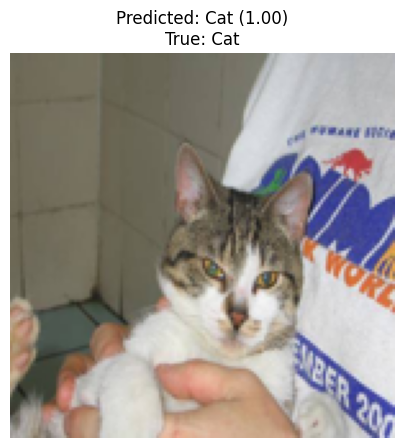

In [16]:
import random

idx = random.randint(0, len(x_val) - 1)
pred = model.predict(np.expand_dims(x_val[idx], axis=0))[0][0]

plt.figure(figsize=(5, 5))
plt.imshow(x_val[idx])
plt.title(f"Predicted: {'Cat' if pred > 0.5 else 'Dog'} ({pred:.2f})\nTrue: {'Cat' if y_val[idx] == 1 else 'Dog'}")
plt.axis('off')
plt.show()

## Conclusion

We successfully fine-tuned a ResNet50 model to classify cats and dogs, achieving good accuracy by leveraging pre-trained weights. This method of transfer learning enables efficient training and high performance with minimal modifications.